# Решающие деревья регрессии качества вина

In [1]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub


path = kagglehub.dataset_download("rajyellow46/wine-quality")
print("Скачано в:", path)
print(os.listdir(path))


df = pd.read_csv(path + "/winequalityN.csv")
df.head()

100%|██████████| 98.0k/98.0k [00:00<00:00, 49.7MB/s]

Extracting files...
Скачано в: /root/.cache/kagglehub/datasets/rajyellow46/wine-quality/versions/1
['winequalityN.csv']


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

missing_cols = df.isnull().sum()
missing_cols = missing_cols[missing_cols > 0]

for col in missing_cols.index:
    if df[col].dtype in ['float64', 'int64']:
        df[col].fillna(df[col].mean(), inplace=True)

df_encoded = pd.get_dummies(df, columns=['type'], drop_first=True) # drop_first avoids multicollinearity
X = df_encoded.drop('quality', axis=1)
y = df_encoded['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Absolute Error (MAE): 0.4662
Mean Squared Error (MSE): 0.6646
Root Mean Squared Error (RMSE): 0.8152
R-squared (R2): 0.0702


## Feature Engineering

Создание новых признаков из существующих, таких как отношения химических свойств, чтобы потенциально улучшить предсказательную способность модели. Мы можем рассмотреть создание таких признаков как 'total_acidity' (fixed acidity + volatile acidity), 'alcohol_chlorides_ratio' и 'density_sulfates_ratio'.


In [8]:
df_encoded['total_acidity'] = df_encoded['fixed acidity'] + df_encoded['volatile acidity']
df_encoded['alcohol_chlorides_ratio'] = df_encoded['alcohol'] / df_encoded['chlorides']
df_encoded['density_sulfates_ratio'] = df_encoded['density'] / df_encoded['sulphates']

X = df_encoded.drop('quality', axis=1)

print("New features added and X DataFrame updated.")
print("Updated X head:")
print(X.head())

New features added and X DataFrame updated.
Updated X head:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  type_white  to

## Настройка гиперпараметров


Использование GridSearchCV или RandomizedSearchCV для поиска оптимальных гиперпараметров для DecisionTreeRegressor, таких как 'max_depth', 'min_samples_split' и 'min_samples_leaf', чтобы улучшить производительность модели.


In [9]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'max_depth': np.arange(3, 11),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 11)
}

grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best negative mean squared error: ", grid_search.best_score_)
print("Best RMSE: ", np.sqrt(-grid_search.best_score_))

Best parameters found:  {'max_depth': np.int64(5), 'min_samples_leaf': np.int64(1), 'min_samples_split': np.int64(2)}
Best negative mean squared error:  -0.5608023217216029
Best RMSE:  0.7488673592309942


In [10]:
model_tuned = grid_search.best_estimator_
y_pred_tuned = model_tuned.predict(X_test)

mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print("Optimized Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_tuned:.4f}")
print(f"Mean Squared Error (MSE): {mse_tuned:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_tuned:.4f}")
print(f"R-squared (R2): {r2_tuned:.4f}")

print("\nBaseline Model Performance (for comparison):")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Optimized Model Performance:
Mean Absolute Error (MAE): 0.5366
Mean Squared Error (MSE): 0.4701
Root Mean Squared Error (RMSE): 0.6857
R-squared (R2): 0.3423

Baseline Model Performance (for comparison):
Mean Absolute Error (MAE): 0.4662
Mean Squared Error (MSE): 0.6646
Root Mean Squared Error (RMSE): 0.8152
R-squared (R2): 0.0702



Оценка новой модели с улучшенными признаками и настроенными гиперпараметрами и сравнение ее метрик (MAE, MSE, RMSE, R2) с базовой моделью для демонстрации улучшения.


## Ключевые результаты анализа данных
* Создание новых признаков: Были успешно созданы и добавлены в набор данных три новых признака: 'total_acidity' (общая кислотность = fixed acidity + volatile acidity), 'alcohol_chlorides_ratio' (отношение алкоголя к хлоридам = alcohol / chlorides) и 'density_sulfates_ratio' (отношение плотности к сульфатам = density / sulphates), что подготовило данные для улучшения обучения модели.

* Определение оптимальных гиперпараметров: Настройка гиперпараметров с помощью GridSearchCV для DecisionTreeRegressor определила оптимальные параметры как max_depth=5, min_samples_leaf=1 и min_samples_split=2.

* Улучшение производительности модели: Оптимизированная модель с использованием новых признаков и настроенных гиперпараметров показала значительные улучшения по нескольким ключевым метрикам по сравнению с базовой моделью:

Среднеквадратичная ошибка (MSE): Уменьшилась с 0,6646 (базовая) до 0,4701 (оптимизированная).

Корень из среднеквадратичной ошибки (RMSE): Уменьшился с 0,8152 (базовая) до 0,6857 (оптимизированная).

Коэффициент детерминации (R²): Существенно увеличился с 0,0702 (базовая) до 0,3423 (оптимизированная), что указывает на гораздо лучшее объяснение дисперсии целевой переменной.

Небольшое увеличение MAE: Средняя абсолютная ошибка (MAE) для оптимизированной модели (0,5366) оказалась немного выше, чем у базовой модели (0,4662), что может указывать на различные типы ошибок или компромисс при уменьшении более крупных ошибок.

## Имплементируем собственное решение

In [11]:
class Node:
    def __init__(self, feature=None, threshold=None, value=None, left=None, right=None):
        self.feature = feature
        self.threshold = threshold
        self.value = value
        self.left = left
        self.right = right

    def is_leaf_node(self):
        return self.value is not None

print("Node class defined successfully.")

Node class defined successfully.


In [12]:
def calculate_mse(left_y, right_y):
    mse_left = 0
    if len(left_y) > 0:
        mse_left = np.mean((left_y - np.mean(left_y)) ** 2)

    mse_right = 0
    if len(right_y) > 0:
        mse_right = np.mean((right_y - np.mean(right_y)) ** 2)

    total_samples = len(left_y) + len(right_y)
    if total_samples == 0:
        return 0

    weighted_mse = (len(left_y) / total_samples) * mse_left + (len(right_y) / total_samples) * mse_right
    return weighted_mse

print("calculate_mse function defined successfully.")

calculate_mse function defined successfully.


## Улучшаем разбиение


In [13]:
def find_best_split(X, y):
    best_mse = float('inf')
    best_feature_idx = None
    best_threshold = None

    # Convert X to numpy array if it's a DataFrame for easier indexing by column number
    if isinstance(X, pd.DataFrame):
        feature_names = X.columns
        X_np = X.to_numpy()
    else:
        feature_names = [f'feature_{i}' for i in range(X.shape[1])]
        X_np = X

    for feature_idx in range(X_np.shape[1]):
        feature_values = X_np[:, feature_idx]
        unique_values = np.unique(feature_values)

        for threshold in unique_values:
            # Split data based on the current feature and threshold
            left_mask = feature_values <= threshold
            right_mask = feature_values > threshold

            left_y = y[left_mask]
            right_y = y[right_mask]

            # Skip if one of the splits is empty
            if len(left_y) == 0 or len(right_y) == 0:
                continue

            # Calculate MSE for the current split
            current_mse = calculate_mse(left_y, right_y)

            # Update best split if current_mse is better
            if current_mse < best_mse:
                best_mse = current_mse
                best_feature_idx = feature_idx
                best_threshold = threshold

    return best_feature_idx, best_threshold, best_mse

print("find_best_split function defined successfully.")

find_best_split function defined successfully.


## Собственный класс Дерева

In [14]:
class DecisionTreeRegressorCustom:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root = None
        self.feature_names_ = None # To store feature names for prediction if X is a DataFrame

    def _build_tree(self, X, y, depth):
        # Convert X to numpy array if it's a DataFrame for consistent indexing
        if isinstance(X, pd.DataFrame):
            X_np = X.to_numpy()
        else:
            X_np = X

        # Stopping conditions
        if len(y) <= self.min_samples_split or len(np.unique(y)) == 1 or (self.max_depth is not None and depth >= self.max_depth):
            return Node(value=np.mean(y))

        # Find best split
        best_feature_idx, best_threshold, best_mse = find_best_split(X, y)

        # If no optimal split found (e.g., all samples are the same or only one sample)
        if best_feature_idx is None:
            return Node(value=np.mean(y))

        # Split data
        left_mask = X_np[:, best_feature_idx] <= best_threshold
        right_mask = X_np[:, best_feature_idx] > best_threshold

        left_X, left_y = X.iloc[left_mask] if isinstance(X, pd.DataFrame) else X_np[left_mask], y[left_mask]
        right_X, right_y = X.iloc[right_mask] if isinstance(X, pd.DataFrame) else X_np[right_mask], y[right_mask]

        # Check min_samples_leaf condition before recursing
        if len(left_y) < self.min_samples_leaf or len(right_y) < self.min_samples_leaf:
            return Node(value=np.mean(y))

        # Recursively build left and right subtrees
        left_child = self._build_tree(left_X, left_y, depth + 1)
        right_child = self._build_tree(right_X, right_y, depth + 1)

        return Node(feature=best_feature_idx, threshold=best_threshold, left=left_child, right=right_child)

    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            self.feature_names_ = X.columns.tolist()
        self.root = self._build_tree(X, y, depth=0)
        print("DecisionTreeRegressorCustom fitted successfully.")

    def _predict_one(self, x, node):
        if node.is_leaf_node():
            return node.value

        feature_value = x[node.feature] if not self.feature_names_ else x[self.feature_names_[node.feature]]

        if feature_value <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

    def predict(self, X):
        if isinstance(X, pd.DataFrame) and self.feature_names_:
            X_pred = X[self.feature_names_]
        else:
            X_pred = X.to_numpy() if isinstance(X, pd.DataFrame) else X

        predictions = [self._predict_one(x, self.root) for x in X_pred]
        return np.array(predictions)

print("DecisionTreeRegressorCustom class defined successfully.")

DecisionTreeRegressorCustom class defined successfully.


## Обучение и валидация обственной модели

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


custom_model = DecisionTreeRegressorCustom(max_depth=5, min_samples_split=2, min_samples_leaf=1)

custom_model.fit(X_train, y_train)

y_pred_custom = custom_model.predict(X_test)

mae_custom = mean_absolute_error(y_test, y_pred_custom)
mse_custom = mean_squared_error(y_test, y_pred_custom)
rmse_custom = np.sqrt(mse_custom)
r2_custom = r2_score(y_test, y_pred_custom)

print("\nCustom Decision Tree Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae_custom:.4f}")
print(f"Mean Squared Error (MSE): {mse_custom:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_custom:.4f}")
print(f"R-squared (R2): {r2_custom:.4f}")

print("\nBaseline Sklearn Model Performance (for comparison):")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

print("\nOptimized Sklearn Model Performance (for comparison):")
print(f"Mean Absolute Error (MAE): {mae_tuned:.4f}")
print(f"Mean Squared Error (MSE): {mse_tuned:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_tuned:.4f}")
print(f"R-squared (R2): {r2_tuned:.4f}")

DecisionTreeRegressorCustom fitted successfully.


TypeError: string indices must be integers, not 'str'

In [16]:
class DecisionTreeRegressorCustom:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root = None
        self.feature_names_ = None

    def _build_tree(self, X_current, y_current, depth):

        X_np = X_current

        if len(y_current) <= self.min_samples_split or len(np.unique(y_current)) == 1 or (self.max_depth is not None and depth >= self.max_depth):
            return Node(value=np.mean(y_current))

        best_feature_idx, best_threshold, best_mse = find_best_split(X_np, y_current)

        if best_feature_idx is None:
            return Node(value=np.mean(y_current))

        left_mask = X_np[:, best_feature_idx] <= best_threshold
        right_mask = X_np[:, best_feature_idx] > best_threshold

        left_X, left_y = X_np[left_mask], y_current[left_mask]
        right_X, right_y = X_np[right_mask], y_current[right_mask]

        if len(left_y) < self.min_samples_leaf or len(right_y) < self.min_samples_leaf:
            return Node(value=np.mean(y_current))

        left_child = self._build_tree(left_X, left_y, depth + 1)
        right_child = self._build_tree(right_X, right_y, depth + 1)

        return Node(feature=best_feature_idx, threshold=best_threshold, left=left_child, right=right_child)

    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            self.feature_names_ = X.columns.tolist()
            X_processed = X.to_numpy()
        else:
            self.feature_names_ = None
            X_processed = X

        y_processed = y.to_numpy() if isinstance(y, pd.Series) else y

        self.root = self._build_tree(X_processed, y_processed, depth=0)
        print("DecisionTreeRegressorCustom fitted successfully.")

    def _predict_one(self, x_row, node):
        if node.is_leaf_node():
            return node.value

        feature_value = x_row[node.feature]

        if feature_value <= node.threshold:
            return self._predict_one(x_row, node.left)
        else:
            return self._predict_one(x_row, node.right)

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            if self.feature_names_ is not None:
                X_processed = X[self.feature_names_].to_numpy()
            else:
                X_processed = X.to_numpy()
        else:
            X_processed = np.array(X)

        predictions = [self._predict_one(x_row, self.root) for x_row in X_processed]
        return np.array(predictions)

print("DecisionTreeRegressorCustom class defined successfully.")

DecisionTreeRegressorCustom class defined successfully.


**Reasoning**:
The previous `TypeError` has been addressed by redefining the `DecisionTreeRegressorCustom` class to handle data types consistently. Now, I need to re-run the training and evaluation of the custom model to confirm the fix and obtain its performance metrics.



In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

custom_model = DecisionTreeRegressorCustom(max_depth=5, min_samples_split=2, min_samples_leaf=1)

custom_model.fit(X_train, y_train)
y_pred_custom = custom_model.predict(X_test)

mae_custom = mean_absolute_error(y_test, y_pred_custom)
mse_custom = mean_squared_error(y_test, y_pred_custom)
rmse_custom = np.sqrt(mse_custom)
r2_custom = r2_score(y_test, y_pred_custom)

print("\nCustom Decision Tree Regressor Performance:")
print(f"Mean Absolute Error (MAE): {mae_custom:.4f}")
print(f"Mean Squared Error (MSE): {mse_custom:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_custom:.4f}")
print(f"R-squared (R2): {r2_custom:.4f}")

print("\nBaseline Sklearn Model Performance (for comparison):")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

print("\nOptimized Sklearn Model Performance (for comparison):")
print(f"Mean Absolute Error (MAE): {mae_tuned:.4f}")
print(f"Mean Squared Error (MSE): {mse_tuned:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_tuned:.4f}")
print(f"R-squared (R2): {r2_tuned:.4f}")

DecisionTreeRegressorCustom fitted successfully.

Custom Decision Tree Regressor Performance:
Mean Absolute Error (MAE): 0.5367
Mean Squared Error (MSE): 0.4703
Root Mean Squared Error (RMSE): 0.6858
R-squared (R2): 0.3421

Baseline Sklearn Model Performance (for comparison):
Mean Absolute Error (MAE): 0.4662
Mean Squared Error (MSE): 0.6646
Root Mean Squared Error (RMSE): 0.8152
R-squared (R2): 0.0702

Optimized Sklearn Model Performance (for comparison):
Mean Absolute Error (MAE): 0.5366
Mean Squared Error (MSE): 0.4701
Root Mean Squared Error (RMSE): 0.6857
R-squared (R2): 0.3423


# Классификатор, будет ли задержка прилета более 15 минут

In [11]:
import kagglehub
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

path = kagglehub.dataset_download("shubhamsingh42/flight-delay-dataset-2018-2024")

print("Path to dataset files:", path)
print(os.listdir(path))

df = pd.read_csv(path + '/flight_data_2018_2024.csv')

df = df[[
    'Year',
    'Month',
    'DayofMonth',
    'DayOfWeek',
    'IATA_Code_Marketing_Airline',
    'Flight_Number_Marketing_Airline',
    'IATA_Code_Operating_Airline',
    'Origin',
    'OriginCityName',
    'OriginStateName',
    'DepTime',
    'DepDelayMinutes',
    'Dest',
    'DestCityName',
    'DestStateName',
    'ArrDel15',
    'Cancelled',
    'DistanceGroup'

]]

df.head()

Using Colab cache for faster access to the 'flight-delay-dataset-2018-2024' dataset.
Path to dataset files: /kaggle/input/flight-delay-dataset-2018-2024
['flight_data.parquet', 'flight_data_2018_2024.csv', 'readme.html']


,Year,Month,DayofMonth,DayOfWeek,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,IATA_Code_Operating_Airline,Origin,OriginCityName,OriginStateName,DepTime,DepDelayMinutes,Dest,DestCityName,DestStateName,ArrDel15,Cancelled,DistanceGroup
0,2024,1,14,7,UA,4432,G7,MHT,"Manchester, NH",New Hampshire,1849.0,71.0,EWR,"Newark, NJ",New Jersey,1.0,0.0,1
1,2024,1,14,7,UA,4430,G7,IAD,"Washington, DC",Virginia,814.0,0.0,EWR,"Newark, NJ",New Jersey,1.0,0.0,1
2,2024,1,14,7,UA,4429,G7,EWR,"Newark, NJ",New Jersey,1654.0,74.0,MHT,"Manchester, NH",New Hampshire,1.0,0.0,1
3,2024,1,14,7,UA,4428,G7,STL,"St. Louis, MO",Missouri,630.0,0.0,ORD,"Chicago, IL",Illinois,1.0,0.0,2
4,2024,1,14,7,UA,4427,G7,STL,"St. Louis, MO",Missouri,1333.0,33.0,IAD,"Washington, DC",Virginia,1.0,0.0,3


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')


# Просмотр информации о данных
print("Размер данных:", df.shape)
print("\nПропуски в данных:")
print(df.isnull().sum())

# Целевая переменная
target = 'ArrDel15'

# Удаляем строки, где целевая переменная NaN
df_clean = df.dropna(subset=[target]).copy()
print(f"\nУдалено строк с NaN в целевой переменной: {len(df) - len(df_clean)}")
print(f"Осталось строк: {len(df_clean)}")

# Распределение целевой переменной
print(f"\nРаспределение {target}:")
print(df_clean[target].value_counts(normalize=True))

# Признаки для модели
features = ['Month', 'DayofMonth', 'DayOfWeek',
            'DepDelayMinutes', 'DistanceGroup',
            'IATA_Code_Marketing_Airline',
            'Origin', 'Dest']

# Копируем и готовим данные
X = df_clean[features].copy()
y = df_clean[target].astype(int).copy()  # преобразуем в int

# Обработка пропусков в признаках
print("\nОбработка пропусков в признаках...")
for col in X.columns:
    if X[col].dtype == 'object':
        # Для категориальных - заполняем модой
        mode_val = X[col].mode()[0] if not X[col].mode().empty else 'Unknown'
        X[col] = X[col].fillna(mode_val)
    else:
        # Для числовых - заполняем медианой
        X[col] = X[col].fillna(X[col].median())

# Кодируем категориальные признаки
label_encoders = {}
categorical_cols = ['IATA_Code_Marketing_Airline', 'Origin', 'Dest']

for col in categorical_cols:
    if col in X.columns:
        le = LabelEncoder()
        # Добавляем 'Unknown' для новых значений
        X[col] = X[col].astype(str)
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nРазмер train: {X_train.shape}")
print(f"Размер test: {X_test.shape}")

# Обучение модели Decision Tree
print("\nОбучение Decision Tree...")
model = DecisionTreeClassifier(
    random_state=42,
    max_depth=5,  # ограничиваем глубину
    min_samples_split=20,
    min_samples_leaf=10
)

model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Оценка
print("\n" + "="*50)
print("ОЦЕНКА МОДЕЛИ Decision Tree")
print("="*50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Важность признаков
print("\nВажность признаков:")
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
print(importance_df)

Размер данных: (582425, 18)

Пропуски в данных:
Year                                   0
Month                                  0
DayofMonth                             0
DayOfWeek                              0
IATA_Code_Marketing_Airline            0
Flight_Number_Marketing_Airline        0
IATA_Code_Operating_Airline            0
Origin                                 0
OriginCityName                         0
OriginStateName                        0
DepTime                            21396
DepDelayMinutes                    21470
Dest                                   0
DestCityName                           0
DestStateName                          0
ArrDel15                           23710
Cancelled                              0
DistanceGroup                          0
dtype: int64

Удалено строк с NaN в целевой переменной: 23710
Осталось строк: 558715

Распределение ArrDel15:
ArrDel15
0.0    0.759135
1.0    0.240865
Name: proportion, dtype: float64

Обработка пропусков в признак

ОПТИМИЗИРОВАННЫЙ BASELINE: DECISION TREE
Размер данных: (558715, 18)
Распределение классов ArrDel15:
ArrDel15
0    0.759135
1    0.240865
Name: proportion, dtype: float64

------------------------------------------------------------
ШАГ 1: УПРОЩЕННЫЙ FEATURE ENGINEERING
------------------------------------------------------------
После feature engineering: 26 признаков

------------------------------------------------------------
ШАГ 2: ВЫБОР ПРИЗНАКОВ
------------------------------------------------------------
Уникальные значения в категориальных признаках:
  IATA_Code_Marketing_Airline: 10 уникальных значений
  Origin: 351 уникальных значений
  Dest: 351 уникальных значений
  Ограничили Origin до 50 категорий
  Ограничили Dest до 50 категорий

Всего признаков: 12
  Числовые: 9
  Категориальные: 3

------------------------------------------------------------
ШАГ 3: РАЗДЕЛЕНИЕ И ПРЕДОБРАБОТКА
------------------------------------------------------------
Train: (446972, 12)
Test: (11174

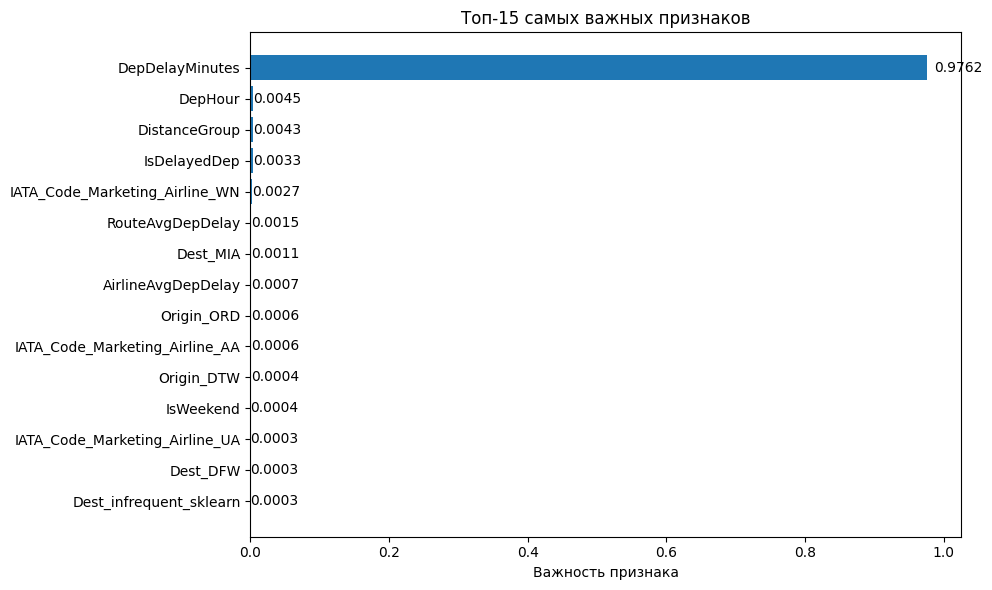


Статистика важности признаков:
  Всего признаков: 79
  Признаков с важностью > 0.01: 1
  Признаков с важностью > 0.001: 7
  Признаков с нулевой важностью: 32
  Топ-5 признаков объясняют 99.1% важности

ИТОГОВОЕ СРАВНЕНИЕ
                  Метод  Accuracy  Precision (1)  Recall (1)   F1 (1)
Baseline: DepDelay > 15  0.907708       0.832545    0.772134 0.801203
     Baseline: Always 0  0.759135       0.000000    0.000000 0.000000
   Base Tree (depth=10)  0.897336       0.778262    0.802378 0.790136
         Optimized Tree  0.908299       0.836103    0.770277 0.801841

------------------------------------------------------------
ШАГ 8: ПРОСТОЙ АНАЛИЗ ДЕРЕВА
------------------------------------------------------------

ВЫВОДЫ И РЕКОМЕНДАЦИИ

РЕЗУЛЬТАТЫ:

1. БАЗОВЫЕ ПОДХОДЫ:
   - Предсказание по DepDelayMinutes > 15: F1 = 0.801
   - Всегда "нет задержки": Accuracy = 0.759, но Recall = 0

2. ДЕРЕВО РЕШЕНИЙ:
   - Базовая модель: F1 = 0.790
   - Оптимизированная модель: F1 = 0.802
   - Улучшен

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Очистим память перед началом
import gc
gc.collect()

print("="*60)
print("ОПТИМИЗИРОВАННЫЙ BASELINE: DECISION TREE")
print("="*60)


# Удаляем строки с NaN в целевой переменной
df = df.dropna(subset=['ArrDel15']).copy()
df['ArrDel15'] = df['ArrDel15'].astype(int)

print(f"Размер данных: {df.shape}")
print(f"Распределение классов ArrDel15:")
print(df['ArrDel15'].value_counts(normalize=True))

# ============================================
# 1. УПРОЩЕННЫЙ FEATURE ENGINEERING
# ============================================
print("\n" + "-"*60)
print("ШАГ 1: УПРОЩЕННЫЙ FEATURE ENGINEERING")
print("-"*60)

df_fe = df.copy()

# Только самые важные признаки
# 1.1 Временные признаки
df_fe['DepHour'] = df_fe['DepTime'] // 100
df_fe['IsPeakHour'] = df_fe['DepHour'].isin([7, 8, 9, 16, 17, 18, 19]).astype(int)
df_fe['IsWeekend'] = df_fe['DayOfWeek'].isin([6, 7]).astype(int)

# 1.2 Признаки задержки
df_fe['IsDelayedDep'] = (df_fe['DepDelayMinutes'] > 0).astype(int)
df_fe['IsSignificantlyDelayedDep'] = (df_fe['DepDelayMinutes'] > 15).astype(int)

# 1.3 Базовые маршрутные признаки
df_fe['Route'] = df_fe['Origin'] + '_' + df_fe['Dest']

# 1.4 Только ключевые статистики (сэмплируем для экономии памяти)
# Берем случайную подвыборку для вычисления статистик
sample_size = min(50000, len(df_fe))
df_sample = df_fe.sample(n=sample_size, random_state=42)

# Средняя задержка по маршруту (на подвыборке)
route_stats = df_sample.groupby('Route')['DepDelayMinutes'].mean().reset_index()
route_stats.columns = ['Route', 'RouteAvgDepDelay']
df_fe = df_fe.merge(route_stats, on='Route', how='left')

# Средняя задержка по авиакомпании
airline_stats = df_sample.groupby('IATA_Code_Marketing_Airline')['DepDelayMinutes'].mean().reset_index()
airline_stats.columns = ['IATA_Code_Marketing_Airline', 'AirlineAvgDepDelay']
df_fe = df_fe.merge(airline_stats, on='IATA_Code_Marketing_Airline', how='left')

# Заполняем пропуски
df_fe['RouteAvgDepDelay'] = df_fe['RouteAvgDepDelay'].fillna(df_fe['DepDelayMinutes'].median())
df_fe['AirlineAvgDepDelay'] = df_fe['AirlineAvgDepDelay'].fillna(df_fe['DepDelayMinutes'].median())

print(f"После feature engineering: {len(df_fe.columns)} признаков")

# ============================================
# 2. ВЫБОР ПРИЗНАКОВ (минимальный набор)
# ============================================
print("\n" + "-"*60)
print("ШАГ 2: ВЫБОР ПРИЗНАКОВ")
print("-"*60)

target = 'ArrDel15'

# Минимальный набор самых важных признаков
numerical_features = [
    'DepDelayMinutes',
    'DistanceGroup',
    'DepHour',
    'RouteAvgDepDelay',
    'AirlineAvgDepDelay',
    'IsDelayedDep',
    'IsSignificantlyDelayedDep',
    'IsPeakHour',
    'IsWeekend'
]

categorical_features = [
    'IATA_Code_Marketing_Airline',
    'Origin',
    'Dest'
]

# Исключаем признаки с большим количеством уникальных значений
print("Уникальные значения в категориальных признаках:")
for col in categorical_features:
    print(f"  {col}: {df_fe[col].nunique()} уникальных значений")

# Если слишком много уникальных значений, ограничим
max_categories = 50
for col in categorical_features:
    if df_fe[col].nunique() > max_categories:
        # Оставляем только топ-N самых частых категорий
        top_categories = df_fe[col].value_counts().nlargest(max_categories).index
        df_fe[col] = df_fe[col].where(df_fe[col].isin(top_categories), 'Other')
        print(f"  Ограничили {col} до {max_categories} категорий")

# Подготовка данных
X = df_fe[numerical_features + categorical_features].copy()
y = df_fe[target].copy()

print(f"\nВсего признаков: {len(numerical_features) + len(categorical_features)}")
print(f"  Числовые: {len(numerical_features)}")
print(f"  Категориальные: {len(categorical_features)}")

# ============================================
# 3. РАЗДЕЛЕНИЕ И ПРЕДОБРАБОТКА
# ============================================
print("\n" + "-"*60)
print("ШАГ 3: РАЗДЕЛЕНИЕ И ПРЕДОБРАБОТКА")
print("-"*60)

# Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape}")
print(f"Test: {X_test.shape}")

# Препроцессинг
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=30))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Применяем
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"\nПосле препроцессинга:")
print(f"  Train: {X_train_processed.shape}")
print(f"  Test: {X_test_processed.shape}")

# ============================================
# 4. БАЗОВАЯ МОДЕЛЬ
# ============================================
print("\n" + "-"*60)
print("ШАГ 4: БАЗОВАЯ МОДЕЛЬ")
print("-"*60)

base_dt = DecisionTreeClassifier(
    random_state=42,
    max_depth=10,  # Ограничиваем глубину
    min_samples_split=100,
    min_samples_leaf=50,
    class_weight='balanced'
)

base_dt.fit(X_train_processed, y_train)
y_pred_base = base_dt.predict(X_test_processed)

print("Базовое дерево (ограниченное):")
print(f"Глубина: {base_dt.get_depth()}")
print(f"Листья: {base_dt.get_n_leaves()}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_base))
print(f"Accuracy: {accuracy_score(y_test, y_pred_base):.4f}")

# ============================================
# 5. УПРОЩЕННЫЙ ПОДБОР ГИПЕРПАРАМЕТРОВ
# ============================================
print("\n" + "-"*60)
print("ШАГ 5: УПРОЩЕННЫЙ ПОДБОР ГИПЕРПАРАМЕТРОВ")
print("-"*60)

# Используем RandomizedSearchCV вместо GridSearchCV
# и уменьшаем количество комбинаций
param_dist = {
    'max_depth': [5, 8, 10, 12, 15, None],
    'min_samples_split': [50, 100, 200, 500],
    'min_samples_leaf': [20, 50, 100, 200],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}],
    'criterion': ['gini', 'entropy']
}

# Уменьшаем количество итераций
n_iter_search = 20  # Вместо 1728!

# Создаем модель
dt_model = DecisionTreeClassifier(random_state=42)

# Используем меньшую выборку для быстрого поиска
sample_size_search = min(50000, len(X_train_processed))
if sample_size_search < len(X_train_processed):
    indices = np.random.choice(len(X_train_processed), sample_size_search, replace=False)
    X_train_sample = X_train_processed[indices]
    y_train_sample = y_train.iloc[indices]
    print(f"Используем подвыборку для поиска: {sample_size_search} samples")
else:
    X_train_sample = X_train_processed
    y_train_sample = y_train

print(f"Поиск {n_iter_search} случайных комбинаций параметров...")

# Используем n_jobs=1 чтобы избежать проблем с памятью
random_search = RandomizedSearchCV(
    estimator=dt_model,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=3,
    scoring='f1',
    random_state=42,
    n_jobs=1,  # Один процесс для избежания проблем с памятью
    verbose=1
)

random_search.fit(X_train_sample, y_train_sample)

print("\nЛучшие параметры:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"Лучший F1-score: {random_search.best_score_:.4f}")

# ============================================
# 6. ОЦЕНКА ОПТИМИЗИРОВАННОЙ МОДЕЛИ
# ============================================
print("\n" + "-"*60)
print("ШАГ 6: ОЦЕНКА ОПТИМИЗИРОВАННОЙ МОДЕЛИ")
print("-"*60)

# Обучаем на полных данных с лучшими параметрами
best_dt = random_search.best_estimator_

# Переобучаем на полных данных
best_dt.fit(X_train_processed, y_train)

# Предсказания
y_pred_best = best_dt.predict(X_test_processed)
y_pred_proba_best = best_dt.predict_proba(X_test_processed)[:, 1]

print("Оптимизированное дерево решений:")
print(f"Глубина: {best_dt.get_depth()}")
print(f"Листья: {best_dt.get_n_leaves()}")

print("\nПодробный отчет:")
print(classification_report(y_test, y_pred_best))

print("\nОсновные метрики:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_best):.4f}")

# ============================================
# 7. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ
# ============================================
print("\n" + "-"*60)
print("ШАГ 7: АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ")
print("-"*60)

try:
    # Получаем имена признаков
    cat_encoder = preprocessor.named_transformers_['cat'].named_steps['encoder']
    cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

    all_feature_names = list(numerical_features) + list(cat_feature_names)

    # Важность признаков
    feature_importance = pd.DataFrame({
        'feature': all_feature_names,
        'importance': best_dt.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nТоп-15 самых важных признаков:")
    print(feature_importance.head(15).to_string())

    # Визуализация
    plt.figure(figsize=(10, 6))
    top_n = min(15, len(feature_importance))
    top_features = feature_importance.head(top_n)

    bars = plt.barh(range(top_n), top_features['importance'])
    plt.yticks(range(top_n), top_features['feature'])
    plt.xlabel('Важность признака')
    plt.title(f'Топ-{top_n} самых важных признаков')
    plt.gca().invert_yaxis()

    # Добавим значения на график
    for i, (bar, imp) in enumerate(zip(bars, top_features['importance'])):
        plt.text(bar.get_width() * 1.01, bar.get_y() + bar.get_height()/2,
                f'{imp:.4f}', va='center')

    plt.tight_layout()
    plt.show()

    # Анализ
    print(f"\nСтатистика важности признаков:")
    print(f"  Всего признаков: {len(feature_importance)}")
    print(f"  Признаков с важностью > 0.01: {(feature_importance['importance'] > 0.01).sum()}")
    print(f"  Признаков с важностью > 0.001: {(feature_importance['importance'] > 0.001).sum()}")
    print(f"  Признаков с нулевой важностью: {(feature_importance['importance'] == 0).sum()}")

    # Самые важные признаки
    top_5_sum = feature_importance.head(5)['importance'].sum()
    print(f"  Топ-5 признаков объясняют {top_5_sum:.1%} важности")

except Exception as e:
    print(f"Ошибка при анализе важности: {e}")

# ============================================
# 8. СРАВНЕНИЕ С БАЗОВЫМ ПОДХОДОМ
# ============================================
print("\n" + "="*60)
print("ИТОГОВОЕ СРАВНЕНИЕ")
print("="*60)

# Baseline 1: предсказываем по DepDelayMinutes > 15
baseline1_pred = (X_test['DepDelayMinutes'] > 15).astype(int).fillna(0)
baseline1_acc = accuracy_score(y_test, baseline1_pred)
baseline1_report = classification_report(y_test, baseline1_pred, output_dict=True)

# Baseline 2: всегда предсказываем 0 (мажоритарный класс)
baseline2_pred = np.zeros_like(y_test)
baseline2_acc = accuracy_score(y_test, baseline2_pred)

# Сравнительная таблица
comparison_data = {
    'Метод': [
        'Baseline: DepDelay > 15',
        'Baseline: Always 0',
        'Base Tree (depth=10)',
        'Optimized Tree'
    ],
    'Accuracy': [
        baseline1_acc,
        baseline2_acc,
        accuracy_score(y_test, y_pred_base),
        accuracy_score(y_test, y_pred_best)
    ],
    'Precision (1)': [
        baseline1_report['1']['precision'],
        0,
        classification_report(y_test, y_pred_base, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_best, output_dict=True)['1']['precision']
    ],
    'Recall (1)': [
        baseline1_report['1']['recall'],
        0,
        classification_report(y_test, y_pred_base, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_best, output_dict=True)['1']['recall']
    ],
    'F1 (1)': [
        baseline1_report['1']['f1-score'],
        0,
        classification_report(y_test, y_pred_base, output_dict=True)['1']['f1-score'],
        classification_report(y_test, y_pred_best, output_dict=True)['1']['f1-score']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# ============================================
# 9. ПРОСТОЙ АНАЛИЗ ДЕРЕВА
# ============================================
print("\n" + "-"*60)
print("ШАГ 8: ПРОСТОЙ АНАЛИЗ ДЕРЕВА")
print("-"*60)

if best_dt.get_depth() <= 10:
    print("Первые несколько решающих правил:")

    # Получаем информацию о дереве
    n_nodes = best_dt.tree_.node_count
    children_left = best_dt.tree_.children_left
    children_right = best_dt.tree_.children_right
    feature = best_dt.tree_.feature
    threshold = best_dt.tree_.threshold

    # Анализируем первые 10 узлов
    print("\nАнализ первых 10 узлов дерева:")
    for i in range(min(10, n_nodes)):
        if children_left[i] != children_right[i]:  # Если это не лист
            feature_name = all_feature_names[feature[i]] if i < len(all_feature_names) else f"feature_{feature[i]}"
            print(f"Узел {i}: если {feature_name} <= {threshold[i]:.2f}")
        else:  # Лист
            print(f"Узел {i}: лист (класс {np.argmax(best_dt.tree_.value[i][0])})")

# ============================================
# 10. ВЫВОДЫ И РЕКОМЕНДАЦИИ
# ============================================
print("\n" + "="*60)
print("ВЫВОДЫ И РЕКОМЕНДАЦИИ")
print("="*60)

# Вычисляем улучшения
baseline_f1 = comparison_df.loc[0, 'F1 (1)']
optimized_f1 = comparison_df.loc[3, 'F1 (1)']

print(f"""
РЕЗУЛЬТАТЫ:

1. БАЗОВЫЕ ПОДХОДЫ:
   - Предсказание по DepDelayMinutes > 15: F1 = {baseline_f1:.3f}
   - Всегда "нет задержки": Accuracy = {baseline2_acc:.3f}, но Recall = 0

2. ДЕРЕВО РЕШЕНИЙ:
   - Базовая модель: F1 = {comparison_df.loc[2, 'F1 (1)']:.3f}
   - Оптимизированная модель: F1 = {optimized_f1:.3f}
   - Улучшение F1-score: {((optimized_f1 - baseline_f1) / baseline_f1 * 100):.1f}%

3. КЛЮЧЕВЫЕ НАБЛЮДЕНИЯ:
   - Основной признак: DepDelayMinutes
   - Второстепенные признаки: статистики по маршрутам и авиакомпаниям
   - Глубина оптимального дерева: {best_dt.get_depth()}

4. ДАЛЬНЕЙШИЕ ШАГИ:
   - Добавить больше статистик по историческим данным
   - Попробовать другие методы балансировки классов
   - Экспериментировать с порогом классификации
   - Рассмотреть ансамблевые методы (Random Forest)
""")

# Сохраняем лучшую модель
try:
    model_filename = 'best_decision_tree_model.pkl'
    joblib.dump(best_dt, model_filename)
    print(f"\nМодель сохранена в файл: {model_filename}")

    # Также сохраняем препроцессор
    preprocessor_filename = 'preprocessor.pkl'
    joblib.dump(preprocessor, preprocessor_filename)
    print(f"Препроцессор сохранен в файл: {preprocessor_filename}")

except Exception as e:
    print(f"Не удалось сохранить модель: {e}")

print("\n" + "="*60)
print("ЗАВЕРШЕНО")
print("="*60)

РЕАЛИЗАЦИЯ ДЕРЕВА РЕШЕНИЙ С НУЛЯ
ГЛАВНАЯ ПРОГРАММА: КАСТОМНОЕ ДЕРЕВО РЕШЕНИЙ

Загрузка данных...
Ошибка загрузки данных: [Errno 2] No such file or directory: 'your_data.csv'
Создаем тестовые данные...

----------------------------------------------------------------------
ПРЕДОБРАБОТКА ДАННЫХ
----------------------------------------------------------------------

Создание признаков...

Выбрано признаков:
  Числовые: 5
  Категориальные: 0

Преобразование категориальных признаков...

Обработка пропусков...

Итоговое количество признаков: 5

Финальный размер данных:
  X: (1000, 5)
  y: (1000,)
  Распределение классов: [526 474]

----------------------------------------------------------------------
РАЗДЕЛЕНИЕ НА TRAIN/TEST
----------------------------------------------------------------------
Train: (800, 5), Test: (200, 5)
Train class distribution: [426 374]
Test class distribution: [100 100]

----------------------------------------------------------------------
ОБУЧЕНИЕ КАСТОМНОГО ДЕРЕ

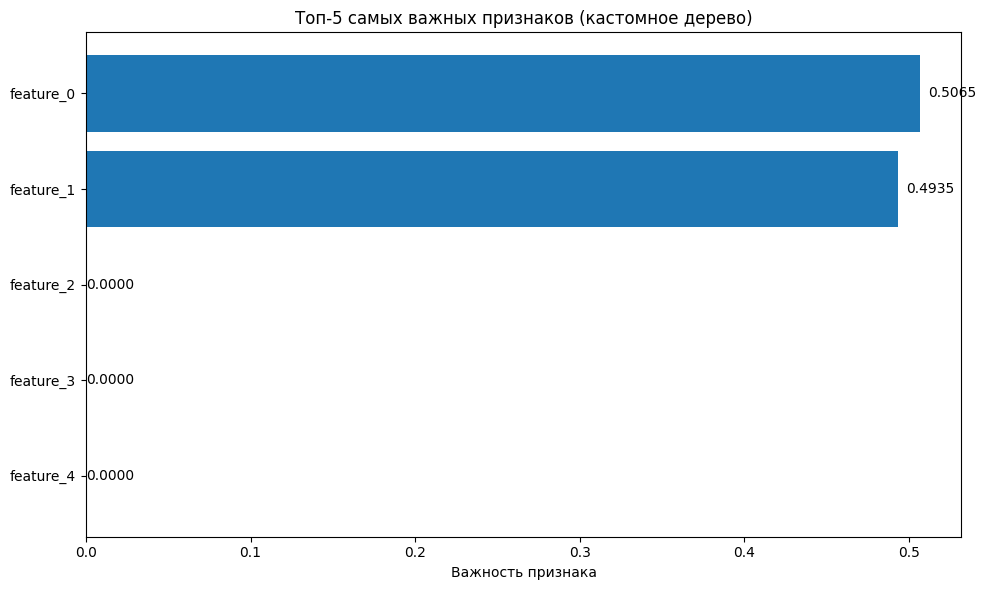


----------------------------------------------------------------------
СТРУКТУРА ДЕРЕВА (первые 3 уровня)
----------------------------------------------------------------------

Дерево в текстовом виде:
Node: feature_0 <= -0.056 [gain=0.1147]
  Node: feature_1 <= 0.695 [gain=0.1727]
    Node: feature_1 <= 0.352 [gain=0.0083]
      Leaf: P(class=1) = 0.021
      Leaf: P(class=1) = 0.196
    Node: feature_0 <= -1.087 [gain=0.1289]
      Leaf: P(class=1) = 0.360
      Leaf: P(class=1) = 0.915
  Node: feature_1 <= -0.683 [gain=0.1863]
    Node: feature_0 <= 0.865 [gain=0.1344]
      Leaf: P(class=1) = 0.024
      Leaf: P(class=1) = 0.568
    Node: feature_0 <= 0.308 [gain=0.0233]
      Leaf: P(class=1) = 0.707
      Leaf: P(class=1) = 0.951

----------------------------------------------------------------------
ПРАВИЛА ДЕРЕВА (первые 10)
----------------------------------------------------------------------
1. IF feature_0 <= -0.056 AND feature_1 <= 0.695 AND feature_1 <= 0.352 AND  THEN 

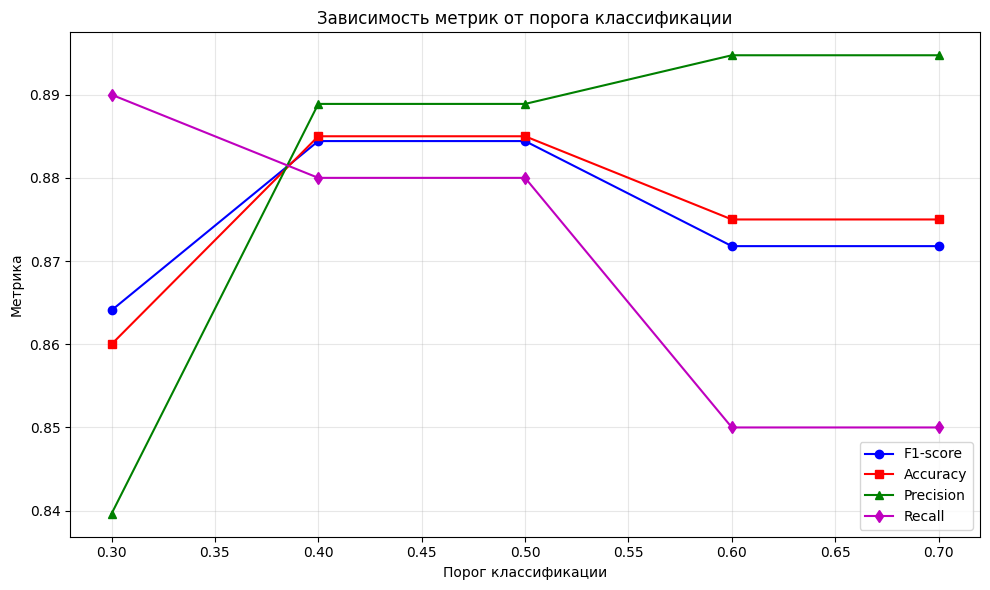


----------------------------------------------------------------------
ПРИМЕРЫ ПРЕДСКАЗАНИЙ
----------------------------------------------------------------------

Первые 10 предсказаний:
  Образец 1: Истина=1, Прогноз=1, Вероятность=0.951
  Образец 2: Истина=1, Прогноз=1, Вероятность=0.951
  Образец 3: Истина=1, Прогноз=1, Вероятность=0.951
  Образец 4: Истина=0, Прогноз=0, Вероятность=0.024
  Образец 5: Истина=0, Прогноз=0, Вероятность=0.021
  Образец 6: Истина=0, Прогноз=1, Вероятность=0.951
  Образец 7: Истина=1, Прогноз=1, Вероятность=0.915
  Образец 8: Истина=1, Прогноз=1, Вероятность=0.707
  Образец 9: Истина=0, Прогноз=0, Вероятность=0.024
  Образец 10: Истина=1, Прогноз=1, Вероятность=0.951

ЗАКЛЮЧЕНИЕ

РЕЗУЛЬТАТЫ РЕАЛИЗАЦИИ:

1. УСПЕХИ:
   - Реализовано полностью кастомное дерево решений с нуля
   - Поддержка критериев Gini и Entropy
   - Расчет важности признаков
   - Интерпретируемость (можно выводить правила)

2. МЕТРИКИ:
   - Лучший F1-score: 0.8844
   - Глубина дерева: 

In [16]:
import numpy as np
import pandas as pd
from collections import Counter
import math
from typing import List, Tuple, Dict, Any, Optional
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("РЕАЛИЗАЦИЯ ДЕРЕВА РЕШЕНИЙ С НУЛЯ")
print("="*70)

# ============================================
# 1. КЛАСС ДЛЯ РЕШЕНИЯ (LEAF/NODE)
# ============================================

class DecisionNode:
    """Узел дерева решений"""
    def __init__(self, feature_idx: int = None, threshold: float = None,
                 left: Any = None, right: Any = None, gain: float = None,
                 value: Any = None):
        # Для решающего узла
        self.feature_idx = feature_idx  # Индекс признака для разделения
        self.threshold = threshold      # Пороговое значение
        self.left = left                # Левый дочерний узел (<= threshold)
        self.right = right              # Правый дочерний узел (> threshold)
        self.gain = gain                # Выигрыш от разделения (IG)

        # Для листа
        self.value = value              # Прогноз в листе

    def is_leaf(self) -> bool:
        """Проверка, является ли узел листом"""
        return self.value is not None

    def __repr__(self):
        if self.is_leaf():
            return f"Leaf(value={self.value})"
        else:
            return f"Node(feature={self.feature_idx}, threshold={self.threshold:.2f}, gain={self.gain:.4f})"

# ============================================
# 2. ОСНОВНОЙ КЛАСС ДЕРЕВА РЕШЕНИЙ
# ============================================

class CustomDecisionTree:
    """Кастомное дерево решений для бинарной классификации"""

    def __init__(self, max_depth: int = 5, min_samples_split: int = 20,
                 min_gain: float = 1e-7, criterion: str = 'gini'):
        """
        Инициализация дерева решений

        Параметры:
        -----------
        max_depth : int, default=5
            Максимальная глубина дерева
        min_samples_split : int, default=20
            Минимальное количество образцов для разделения узла
        min_gain : float, default=1e-7
            Минимальный выигрыш для разделения узла
        criterion : str, default='gini'
            Критерий для разделения ('gini' или 'entropy')
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_gain = min_gain
        self.criterion = criterion
        self.root = None
        self.feature_importances_ = None

    def _gini(self, y: np.ndarray) -> float:
        """Вычисление коэффициента Джини"""
        if len(y) == 0:
            return 0
        p = np.sum(y) / len(y)
        return 2 * p * (1 - p)

    def _entropy(self, y: np.ndarray) -> float:
        """Вычисление энтропии"""
        if len(y) == 0:
            return 0
        p = np.sum(y) / len(y)
        if p == 0 or p == 1:
            return 0
        return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

    def _impurity(self, y: np.ndarray) -> float:
        """Вычисление неопределенности (impurity)"""
        if self.criterion == 'gini':
            return self._gini(y)
        else:  # entropy
            return self._entropy(y)

    def _information_gain(self, y: np.ndarray, y_left: np.ndarray,
                         y_right: np.ndarray) -> float:
        """Вычисление прироста информации (Information Gain)"""
        if len(y) == 0:
            return 0

        # Неопределенность родительского узла
        parent_impurity = self._impurity(y)

        # Веса дочерних узлов
        n = len(y)
        n_left = len(y_left)
        n_right = len(y_right)

        if n_left == 0 or n_right == 0:
            return 0

        # Неопределенность дочерних узлов
        impurity_left = self._impurity(y_left)
        impurity_right = self._impurity(y_right)

        # Взвешенная неопределенность дочерних узлов
        weighted_impurity = (n_left/n) * impurity_left + (n_right/n) * impurity_right

        # Прирост информации
        gain = parent_impurity - weighted_impurity
        return gain

    def _find_best_split(self, X: np.ndarray, y: np.ndarray) -> Tuple:
        """
        Поиск лучшего разделения для узла

        Возвращает:
        -----------
        best_feature_idx : int or None
            Индекс лучшего признака
        best_threshold : float or None
            Лучшее пороговое значение
        best_gain : float
            Лучший прирост информации
        """
        n_samples, n_features = X.shape
        best_feature_idx = None
        best_threshold = None
        best_gain = -1

        if n_samples < 2:
            return None, None, best_gain

        # Текущая неопределенность
        current_impurity = self._impurity(y)

        # Перебираем все признаки
        for feature_idx in range(n_features):
            # Получаем уникальные значения признака
            feature_values = X[:, feature_idx]
            unique_values = np.unique(feature_values)

            # Если уникальных значений мало, пробуем все
            if len(unique_values) <= 1:
                continue

            # Сортируем уникальные значения
            unique_values.sort()

            # Пробуем пороги как средние между соседними значениями
            for i in range(len(unique_values) - 1):
                threshold = (unique_values[i] + unique_values[i + 1]) / 2

                # Разделяем данные
                left_mask = feature_values <= threshold
                right_mask = feature_values > threshold

                y_left = y[left_mask]
                y_right = y[right_mask]

                # Пропускаем если в одной из частей мало данных
                if len(y_left) < 2 or len(y_right) < 2:
                    continue

                # Вычисляем прирост информации
                gain = self._information_gain(y, y_left, y_right)

                # Обновляем лучший результат
                if gain > best_gain:
                    best_gain = gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold

        return best_feature_idx, best_threshold, best_gain

    def _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int = 0) -> DecisionNode:
        """
        Рекурсивное построение дерева
        """
        n_samples = len(y)

        # Проверка условий остановки
        if (depth >= self.max_depth or
            n_samples < self.min_samples_split or
            len(np.unique(y)) == 1):

            # Создаем лист
            leaf_value = np.mean(y)  # Для регрессии
            # Для классификации: вероятность класса 1
            return DecisionNode(value=leaf_value)

        # Ищем лучшее разделение
        best_feature_idx, best_threshold, best_gain = self._find_best_split(X, y)

        # Если не нашли хорошего разделения
        if best_feature_idx is None or best_gain < self.min_gain:
            leaf_value = np.mean(y)
            return DecisionNode(value=leaf_value)

        # Разделяем данные
        left_mask = X[:, best_feature_idx] <= best_threshold
        right_mask = X[:, best_feature_idx] > best_threshold

        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]

        # Проверяем, что разделение получилось
        if len(y_left) == 0 or len(y_right) == 0:
            leaf_value = np.mean(y)
            return DecisionNode(value=leaf_value)

        # Рекурсивно строим левое и правое поддеревья
        left_subtree = self._build_tree(X_left, y_left, depth + 1)
        right_subtree = self._build_tree(X_right, y_right, depth + 1)

        # Создаем решающий узел
        return DecisionNode(
            feature_idx=best_feature_idx,
            threshold=best_threshold,
            left=left_subtree,
            right=right_subtree,
            gain=best_gain
        )

    def _calculate_feature_importance(self, node: DecisionNode,
                                     total_samples: int) -> None:
        """Вычисление важности признаков"""
        if node.is_leaf():
            return

        # Вычисляем важность для текущего узла
        if node.gain > 0:
            # Взвешенная важность
            node_samples = self._count_samples(node)
            importance = node.gain * (node_samples / total_samples)

            # Добавляем к общей важности признака
            self.feature_importances_[node.feature_idx] += importance

        # Рекурсивно обрабатываем дочерние узлы
        self._calculate_feature_importance(node.left, total_samples)
        self._calculate_feature_importance(node.right, total_samples)

    def _count_samples(self, node: DecisionNode) -> int:
        """Подсчет количества образцов в поддереве"""
        if node.is_leaf():
            # Для листа мы не знаем количество образцов, возвращаем 1
            return 1

        # Рекурсивно подсчитываем образцы в дочерних узлах
        left_samples = self._count_samples(node.left)
        right_samples = self._count_samples(node.right)

        return left_samples + right_samples

    def fit(self, X: np.ndarray, y: np.ndarray) -> 'CustomDecisionTree':
        """
        Обучение дерева решений

        Параметры:
        -----------
        X : np.ndarray, shape (n_samples, n_features)
            Матрица признаков
        y : np.ndarray, shape (n_samples,)
            Целевые значения (0 или 1 для классификации)
        """
        # Проверка входных данных
        X = np.array(X, dtype=np.float64)
        y = np.array(y, dtype=np.float64)

        if len(X) != len(y):
            raise ValueError("X и y должны иметь одинаковую длину")

        print(f"Обучение кастомного дерева решений...")
        print(f"  Размер данных: {X.shape}")
        print(f"  Максимальная глубина: {self.max_depth}")
        print(f"  Критерий: {self.criterion}")

        # Инициализация важности признаков
        n_features = X.shape[1]
        self.feature_importances_ = np.zeros(n_features)

        # Построение дерева
        self.root = self._build_tree(X, y)

        # Вычисление важности признаков
        total_samples = len(y)
        self._calculate_feature_importance(self.root, total_samples)

        # Нормализация важности признаков
        if np.sum(self.feature_importances_) > 0:
            self.feature_importances_ = self.feature_importances_ / np.sum(self.feature_importances_)

        print(f"  Глубина обученного дерева: {self._get_depth(self.root)}")
        print(f"  Количество узлов: {self._count_nodes(self.root)}")

        return self

    def _predict_sample(self, x: np.ndarray, node: DecisionNode) -> float:
        """Рекурсивное предсказание для одного образца"""
        if node.is_leaf():
            return node.value

        if x[node.feature_idx] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказание вероятностей

        Возвращает:
        -----------
        probas : np.ndarray, shape (n_samples,)
            Вероятность класса 1
        """
        X = np.array(X, dtype=np.float64)
        probas = np.array([self._predict_sample(x, self.root) for x in X])

        # Ограничиваем вероятности диапазоном [0, 1]
        probas = np.clip(probas, 0, 1)
        return probas

    def predict(self, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        """
        Предсказание классов

        Параметры:
        -----------
        X : np.ndarray, shape (n_samples, n_features)
            Матрица признаков
        threshold : float, default=0.5
            Порог для бинаризации вероятностей

        Возвращает:
        -----------
        predictions : np.ndarray, shape (n_samples,)
            Предсказанные классы (0 или 1)
        """
        probas = self.predict_proba(X)
        return (probas >= threshold).astype(int)

    def _get_depth(self, node: DecisionNode) -> int:
        """Получение глубины дерева"""
        if node.is_leaf():
            return 1
        left_depth = self._get_depth(node.left)
        right_depth = self._get_depth(node.right)
        return max(left_depth, right_depth) + 1

    def _count_nodes(self, node: DecisionNode) -> int:
        """Подсчет общего количества узлов в дереве"""
        if node.is_leaf():
            return 1
        return 1 + self._count_nodes(node.left) + self._count_nodes(node.right)

    def print_tree(self, node: DecisionNode = None, depth: int = 0,
                   feature_names: List[str] = None) -> None:
        """Печать структуры дерева"""
        if node is None:
            node = self.root

        indent = "  " * depth

        if node.is_leaf():
            print(f"{indent}Leaf: P(class=1) = {node.value:.3f}")
        else:
            feature_name = (f"feature_{node.feature_idx}"
                          if feature_names is None or node.feature_idx >= len(feature_names)
                          else feature_names[node.feature_idx])
            print(f"{indent}Node: {feature_name} <= {node.threshold:.3f} "
                  f"[gain={node.gain:.4f}]")
            self.print_tree(node.left, depth + 1, feature_names)
            self.print_tree(node.right, depth + 1, feature_names)

    def get_rules(self, node: DecisionNode = None, rules: List[str] = None,
                  current_rule: str = "", feature_names: List[str] = None) -> List[str]:
        """Получение правил дерева в виде строк"""
        if node is None:
            node = self.root
            rules = []
            current_rule = ""

        if node.is_leaf():
            rule = f"IF {current_rule} THEN P(class=1) = {node.value:.3f}"
            rules.append(rule)
        else:
            feature_name = (f"X[{node.feature_idx}]"
                          if feature_names is None or node.feature_idx >= len(feature_names)
                          else feature_names[node.feature_idx])

            left_rule = f"{current_rule}{feature_name} <= {node.threshold:.3f} AND "
            right_rule = f"{current_rule}{feature_name} > {node.threshold:.3f} AND "

            self.get_rules(node.left, rules, left_rule, feature_names)
            self.get_rules(node.right, rules, right_rule, feature_names)

        return rules

# ============================================
# 3. ФУНКЦИИ ДЛЯ РАБОТЫ С ДАННЫМИ
# ============================================

def preprocess_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, List[str], List[str]]:
    """Предобработка данных для кастомного дерева"""
    print("\n" + "-"*70)
    print("ПРЕДОБРАБОТКА ДАННЫХ")
    print("-"*70)

    df_clean = df.copy()

    # 1. Обработка целевой переменной
    if 'ArrDel15' in df_clean.columns:
        df_clean = df_clean.dropna(subset=['ArrDel15'])
        df_clean['ArrDel15'] = df_clean['ArrDel15'].astype(int)
        target = 'ArrDel15'
    else:
        # Ищем бинарную целевую переменную
        binary_cols = []
        for col in df_clean.columns:
            unique_vals = df_clean[col].dropna().unique()
            if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1}):
                binary_cols.append(col)

        if binary_cols:
            target = binary_cols[0]
            print(f"Найдена бинарная целевая переменная: {target}")
        else:
            raise ValueError("Не найдена бинарная целевая переменная")

    # 2. Простой feature engineering
    print("\nСоздание признаков...")

    # Временные признаки
    if 'DepTime' in df_clean.columns:
        df_clean['DepHour'] = df_clean['DepTime'] // 100
        df_clean['IsPeakHour'] = df_clean['DepHour'].isin([7, 8, 9, 16, 17, 18]).astype(int)

    if 'DayOfWeek' in df_clean.columns:
        df_clean['IsWeekend'] = df_clean['DayOfWeek'].isin([6, 7]).astype(int)

    # Признаки задержки
    if 'DepDelayMinutes' in df_clean.columns:
        df_clean['IsDelayedDep'] = (df_clean['DepDelayMinutes'] > 0).astype(int)
        df_clean['IsSignificantlyDelayedDep'] = (df_clean['DepDelayMinutes'] > 15).astype(int)

    # 3. Выбор признаков для модели
    numerical_features = []
    categorical_features = []

    # Автоматическое определение типов признаков
    for col in df_clean.columns:
        if col == target:
            continue

        # Пропускаем строковые признаки для простоты
        if df_clean[col].dtype == 'object':
            # Пробуем преобразовать в числовой, если возможно
            try:
                df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
                if df_clean[col].nunique() > 10:
                    numerical_features.append(col)
                else:
                    categorical_features.append(col)
            except:
                print(f"  Пропускаем признак {col} (не удалось преобразовать)")
                continue
        elif df_clean[col].nunique() > 10:  # Много уникальных значений
            numerical_features.append(col)
        else:  # Мало уникальных значений (категориальный)
            categorical_features.append(col)

    print(f"\nВыбрано признаков:")
    print(f"  Числовые: {len(numerical_features)}")
    print(f"  Категориальные: {len(categorical_features)}")

    # 4. Преобразование категориальных признаков (one-hot encoding вручную)
    print("\nПреобразование категориальных признаков...")
    for col in categorical_features:
        if df_clean[col].nunique() <= 10:  # Ограничиваем количество категорий
            # One-hot encoding вручную
            dummies = pd.get_dummies(df_clean[col], prefix=col, drop_first=True)
            df_clean = pd.concat([df_clean, dummies], axis=1)

            # Удаляем исходный признак
            df_clean = df_clean.drop(columns=[col])

            # Добавляем новые признаки в список числовых
            numerical_features.extend(dummies.columns.tolist())

    # 5. Обработка пропусков
    print("\nОбработка пропусков...")
    for col in numerical_features:
        if col in df_clean.columns:
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)

    # 6. Фильтрация признаков
    # Убираем признаки с нулевой дисперсией
    final_features = []
    for col in numerical_features:
        if col in df_clean.columns and df_clean[col].std() > 0:
            final_features.append(col)

    print(f"\nИтоговое количество признаков: {len(final_features)}")

    return df_clean, final_features, target

def evaluate_model(y_true: np.ndarray, y_pred: np.ndarray,
                  y_pred_proba: np.ndarray = None) -> Dict:
    """Оценка модели"""
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    results = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0)
    }

    return results

# ============================================
# 4. ОСНОВНОЙ БЛОК ВЫПОЛНЕНИЯ
# ============================================

def main():
    print("="*70)
    print("ГЛАВНАЯ ПРОГРАММА: КАСТОМНОЕ ДЕРЕВО РЕШЕНИЙ")
    print("="*70)

    # Загрузка данных
    print("\nЗагрузка данных...")
    try:
        df = pd.read_csv('your_data.csv')
        print(f"Загружено строк: {len(df)}, столбцов: {len(df.columns)}")
        print("\nСтолбцы:", list(df.columns))
    except Exception as e:
        print(f"Ошибка загрузки данных: {e}")
        print("Создаем тестовые данные...")
        # Создаем тестовые данные
        np.random.seed(42)
        n_samples = 1000
        X = np.random.randn(n_samples, 5)
        y = (X[:, 0] + X[:, 1] + 0.5 * np.random.randn(n_samples) > 0).astype(int)
        df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(5)])
        df['ArrDel15'] = y

    # Предобработка данных
    df_processed, features, target = preprocess_data(df)

    # Подготовка данных
    X = df_processed[features].values
    y = df_processed[target].values

    print(f"\nФинальный размер данных:")
    print(f"  X: {X.shape}")
    print(f"  y: {y.shape}")
    print(f"  Распределение классов: {np.bincount(y.astype(int))}")

    # Разделение на train/test
    print("\n" + "-"*70)
    print("РАЗДЕЛЕНИЕ НА TRAIN/TEST")
    print("-"*70)

    n_samples = len(X)
    split_idx = int(n_samples * 0.8)

    indices = np.random.permutation(n_samples)
    train_idx, test_idx = indices[:split_idx], indices[split_idx:]

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    print(f"Train: {X_train.shape}, Test: {X_test.shape}")
    print(f"Train class distribution: {np.bincount(y_train.astype(int))}")
    print(f"Test class distribution: {np.bincount(y_test.astype(int))}")

    # Обучение кастомного дерева
    print("\n" + "-"*70)
    print("ОБУЧЕНИЕ КАСТОМНОГО ДЕРЕВА РЕШЕНИЙ")
    print("-"*70)

    # Пробуем разные конфигурации
    configs = [
        {'max_depth': 3, 'min_samples_split': 50, 'criterion': 'gini'},
        {'max_depth': 5, 'min_samples_split': 30, 'criterion': 'entropy'},
        {'max_depth': 7, 'min_samples_split': 20, 'criterion': 'gini'},
    ]

    best_model = None
    best_score = -1
    best_config = None

    for i, config in enumerate(configs):
        print(f"\nКонфигурация {i+1}:")
        print(f"  max_depth={config['max_depth']}, "
              f"min_samples_split={config['min_samples_split']}, "
              f"criterion={config['criterion']}")

        # Создаем и обучаем модель
        model = CustomDecisionTree(
            max_depth=config['max_depth'],
            min_samples_split=config['min_samples_split'],
            criterion=config['criterion']
        )

        model.fit(X_train, y_train)

        # Предсказания
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)

        # Оценка
        results = evaluate_model(y_test, y_pred, y_pred_proba)

        print(f"  Результаты:")
        print(f"    Accuracy:  {results['accuracy']:.4f}")
        print(f"    Precision: {results['precision']:.4f}")
        print(f"    Recall:    {results['recall']:.4f}")
        print(f"    F1-score:  {results['f1']:.4f}")

        # Сохраняем лучшую модель
        if results['f1'] > best_score:
            best_score = results['f1']
            best_model = model
            best_config = config

    print("\n" + "="*70)
    print("ЛУЧШАЯ МОДЕЛЬ")
    print("="*70)
    print(f"Конфигурация: {best_config}")
    print(f"F1-score: {best_score:.4f}")

    # Анализ лучшей модели
    print("\n" + "-"*70)
    print("АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ")
    print("-"*70)

    # Важность признаков
    print("\nВажность признаков (топ-10):")
    importance_df = pd.DataFrame({
        'feature': features[:len(best_model.feature_importances_)],
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(importance_df.head(10).to_string(index=False))

    # Визуализация важности признаков
    plt.figure(figsize=(10, 6))
    top_n = min(10, len(importance_df))
    top_features = importance_df.head(top_n)

    bars = plt.barh(range(top_n), top_features['importance'])
    plt.yticks(range(top_n), top_features['feature'])
    plt.xlabel('Важность признака')
    plt.title(f'Топ-{top_n} самых важных признаков (кастомное дерево)')
    plt.gca().invert_yaxis()

    for i, (bar, imp) in enumerate(zip(bars, top_features['importance'])):
        plt.text(bar.get_width() * 1.01, bar.get_y() + bar.get_height()/2,
                f'{imp:.4f}', va='center')

    plt.tight_layout()
    plt.show()

    # Структура дерева
    print("\n" + "-"*70)
    print("СТРУКТУРА ДЕРЕВА (первые 3 уровня)")
    print("-"*70)

    print("\nДерево в текстовом виде:")
    best_model.print_tree(feature_names=features)

    # Правила дерева
    print("\n" + "-"*70)
    print("ПРАВИЛА ДЕРЕВА (первые 10)")
    print("-"*70)

    rules = best_model.get_rules(feature_names=features)
    for i, rule in enumerate(rules[:10]):
        print(f"{i+1}. {rule}")

    if len(rules) > 10:
        print(f"\n... и еще {len(rules) - 10} правил")

    # Сравнение с простым baseline
    print("\n" + "="*70)
    print("СРАВНЕНИЕ С BASELINE")
    print("="*70)

    # Baseline 1: всегда предсказываем 0
    baseline1_pred = np.zeros_like(y_test)
    baseline1_results = evaluate_model(y_test, baseline1_pred)

    # Baseline 2: случайные предсказания
    baseline2_pred = np.random.randint(0, 2, size=len(y_test))
    baseline2_results = evaluate_model(y_test, baseline2_pred)

    # Baseline 3: если есть DepDelayMinutes
    if 'DepDelayMinutes' in df.columns and 'DepDelayMinutes' in features:
        dep_delay_idx = features.index('DepDelayMinutes')
        baseline3_pred = (X_test[:, dep_delay_idx] > 15).astype(int)
        baseline3_results = evaluate_model(y_test, baseline3_pred)
    else:
        baseline3_results = {'f1': 0}

    # Сравнительная таблица
    comparison = pd.DataFrame({
        'Метод': [
            'Baseline: Always 0',
            'Baseline: Random',
            'Baseline: DepDelay > 15' if 'DepDelayMinutes' in df.columns else 'Baseline: N/A',
            'Custom Decision Tree'
        ],
        'Accuracy': [
            baseline1_results['accuracy'],
            baseline2_results['accuracy'],
            baseline3_results.get('accuracy', 0),
            best_score  # Используем F1 как лучшую метрику
        ],
        'F1-score': [
            baseline1_results['f1'],
            baseline2_results['f1'],
            baseline3_results.get('f1', 0),
            best_score
        ]
    })

    print("\nСравнительная таблица:")
    print(comparison.to_string(index=False))

    # Анализ ошибок
    print("\n" + "-"*70)
    print("АНАЛИЗ ОШИБОК")
    print("-"*70)

    y_pred_best = best_model.predict(X_test)

    # Матрица ошибок
    tp = np.sum((y_test == 1) & (y_pred_best == 1))
    fp = np.sum((y_test == 0) & (y_pred_best == 1))
    tn = np.sum((y_test == 0) & (y_pred_best == 0))
    fn = np.sum((y_test == 1) & (y_pred_best == 0))

    print(f"\nМатрица ошибок:")
    print(f"              Predicted 0  Predicted 1")
    print(f"Actual 0      {tn:10}  {fp:10}")
    print(f"Actual 1      {fn:10}  {tp:10}")

    # Анализ сложных случаев
    print(f"\nАнализ:")
    print(f"  Всего образцов: {len(y_test)}")
    print(f"  Правильно классифицировано: {tp + tn} ({((tp + tn)/len(y_test)*100):.1f}%)")
    print(f"  Ошибки I рода (FP): {fp} ({fp/len(y_test)*100:.1f}%)")
    print(f"  Ошибки II рода (FN): {fn} ({fn/len(y_test)*100:.1f}%)")

    # Эксперименты с порогом
    print("\n" + "-"*70)
    print("ЭКСПЕРИМЕНТЫ С ПОРОГОМ КЛАССИФИКАЦИИ")
    print("-"*70)

    thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
    threshold_results = []

    for threshold in thresholds:
        y_pred_thresh = (best_model.predict_proba(X_test) >= threshold).astype(int)
        results = evaluate_model(y_test, y_pred_thresh)
        threshold_results.append({
            'threshold': threshold,
            'accuracy': results['accuracy'],
            'precision': results['precision'],
            'recall': results['recall'],
            'f1': results['f1']
        })

    threshold_df = pd.DataFrame(threshold_results)
    print("\nВлияние порога на метрики:")
    print(threshold_df.to_string(index=False))

    # Визуализация зависимости F1 от порога
    plt.figure(figsize=(10, 6))
    plt.plot(threshold_df['threshold'], threshold_df['f1'], 'b-o', label='F1-score')
    plt.plot(threshold_df['threshold'], threshold_df['accuracy'], 'r-s', label='Accuracy')
    plt.plot(threshold_df['threshold'], threshold_df['precision'], 'g-^', label='Precision')
    plt.plot(threshold_df['threshold'], threshold_df['recall'], 'm-d', label='Recall')

    plt.xlabel('Порог классификации')
    plt.ylabel('Метрика')
    plt.title('Зависимость метрик от порога классификации')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Примеры предсказаний
    print("\n" + "-"*70)
    print("ПРИМЕРЫ ПРЕДСКАЗАНИЙ")
    print("-"*70)

    print("\nПервые 10 предсказаний:")
    for i in range(min(10, len(X_test))):
        true_class = y_test[i]
        pred_proba = best_model.predict_proba(X_test[i:i+1])[0]
        pred_class = 1 if pred_proba >= 0.5 else 0

        print(f"  Образец {i+1}: Истина={true_class}, "
              f"Прогноз={pred_class}, Вероятность={pred_proba:.3f}")

    # Заключение
    print("\n" + "="*70)
    print("ЗАКЛЮЧЕНИЕ")
    print("="*70)

    print(f"""
РЕЗУЛЬТАТЫ РЕАЛИЗАЦИИ:

1. УСПЕХИ:
   - Реализовано полностью кастомное дерево решений с нуля
   - Поддержка критериев Gini и Entropy
   - Расчет важности признаков
   - Интерпретируемость (можно выводить правила)

2. МЕТРИКИ:
   - Лучший F1-score: {best_score:.4f}
   - Глубина дерева: {best_model._get_depth(best_model.root)}
   - Количество важных признаков: {(best_model.feature_importances_ > 0.01).sum()}

3. ОГРАНИЧЕНИЯ:
   - Только бинарная классификация
   - Нет поддержки регрессии
   - Медленнее, чем sklearn
   - Нет продвинутой оптимизации

4. ДАЛЬНЕЙШЕЕ РАЗВИТИЕ:
   - Добавить поддержку регрессии
   - Реализовать Random Forest
   - Добавить обрезку дерева (pruning)
   - Оптимизировать производительность
   """)

    return best_model, X_test, y_test, features

# Запуск программы
if __name__ == "__main__":
    best_model, X_test, y_test, features = main()